In [1]:
from HeaderP import *
import pandas as pd

In [2]:
galah_apogee=pd.read_pickle('Data/GALAH_APOGEE_APOCAN.pkl').reset_index(drop=True)

In [3]:
sourceid=galah_apogee['sobject_id'].values


In [4]:
spec=np.zeros((len(sourceid),13))

from astropy.io import fits
spname='/Users/yl4331/Desktop/CreateDataTable/Data/GALAH_APOGEE_APOCAN_Spectra/'
for i in range(len(sourceid)):
    count=0
    spec[i,-1]=sourceid[i]
    for j in range(4):
        newspname=spname+str(int(sourceid[i]))+str(j+1)+'.fits'
        
        try:
            data=fits.open(newspname)[0]
            spec[i,count]=data.header['CRVAL1']
            spec[i,count+1]=data.header['CDELT1']*len(data.data)+spec[i,count]
            spec[i,count+2]=len(data.data)
            count=count+3
        except:
            spec[i,count]=np.nan
            spec[i,count+1]=np.nan
            spec[i,count+2]=np.nan
            count=count+3
        


In [5]:
useablespec=pd.DataFrame(spec).dropna().values
np.shape(useablespec)

(745, 13)

In [6]:
for i in range(13):
    print(max(useablespec[:,i]))

4714.50439453121
4902.894138120954
4109.0
5650.40087890631
5874.239706745138
4121.0
6480.07763671871
6738.7803272591555
4147.0
7586.51708984371
7887.790880527954
4108.0
190225002701223.0


In [524]:
from scipy import interpolate
def interpolate_to_grid(xdata, ydata, xgrid):
    f = interpolate.interp1d(xdata, ydata)
    new_ydata= f(xgrid)
    return xgrid, new_ydata
    
def get_pixmask(fluxes, flux_errs):
    """ Create and return a bad pixel mask for an APOGEE spectrum

    Bad pixels are defined as follows: fluxes or errors are not finite, or 
    reported errors are <= 0, or fluxes are 0

    Parameters
    ----------
    fluxes: ndarray
        Flux data values 

    flux_errs: ndarray
        Flux uncertainty data values 

    Returns
    -------
    mask: ndarray
        Bad pixel mask, value of True corresponds to bad pixels
    """
    bad_flux = np.logical_or(~np.isfinite(fluxes), fluxes == 0)
    bad_err = (~np.isfinite(flux_errs)) | (flux_errs <= 0)
    bad_pix = bad_err | bad_flux

def get_outliers(fluxes, flux_errs, softenp=5, f=3):
    normflux=pd.Series(fluxes).rolling(softenp,center=True).median()
    outliers=abs(fluxes-normflux)/flux_errs>f
    return normflux,np.asarray(outliers,dtype=bool)

def replace_outliers(fluxes, ivar, softenp=5, f=3):
    flux_errs=np.sqrt(1/ivar)*fluxes
    normflux,outliers=get_outliers(fluxes, flux_errs, softenp=softenp, f=f)
    fluxes[outliers]=normflux[outliers]
    ivar[outliers]=1e-5
    outlier2=fluxes>1.5
    
    fluxes[outlier2]=1.5
    ivar[outlier2]=1e-5
    return fluxes, ivar
    

In [700]:
wl=np.zeros((4096,4))
count=0
for i in range(4):
    wl[:,i]=np.linspace(max(useablespec[:,count]),min(useablespec[:,count+1]),4096)
    count=count+3

In [702]:
import scipy
fluxs=np.zeros((4096,4,np.shape(useablespec)[0]))
ivars=np.zeros((4096,4,np.shape(useablespec)[0]))
for i in range(np.shape(useablespec)[0]):
    spname='/Users/yl4331/Desktop/CreateDataTable/Data/GALAH_APOGEE_APOCAN_Spectra/'
    count=0
    for j in range(4):
        # read in spectra
        newspname=spname+str(int(useablespec[i,-1]))+str(j+1)+'.fits'
        
        # get what the old wl is
        wl_old=np.linspace(useablespec[i,count],useablespec[i,count+1],int(useablespec[i,count+2]))
        count=count+3
         
        # get old flux/ivar
        flux=fits.open(newspname)[0].data # load in unnormalized flux
        ivar=fits.open(newspname)[1].data*flux # load in ivar
        
        __, new_flux = interpolate_to_grid(wl_old, flux, wl[:,j]) # on common grid
        __, new_ivar = interpolate_to_grid(wl_old, ivar, wl[:,j]) # on common grid
        
        normflux=scipy.ndimage.gaussian_filter1d(new_flux, 500)
        flux_norm = new_flux/normflux # normalize flux
        ivar_norm = 1./(new_ivar/normflux)**2 # normalize ivar
        flux_norm,ivar_norm=replace_outliers(flux_norm,ivar_norm, softenp=10, f=3)
        
        fluxs[:,j,i]=flux_norm
        ivars[:,j,i]=ivar_norm
        
        
        

In [ ]:
### use the normalized flux
import scipy
fluxs=np.zeros((4096,4,np.shape(useablespec)[0]))
ivars=np.zeros((4096,4,np.shape(useablespec)[0]))
for i in range(np.shape(useablespec)[0]):
    spname='/Users/yl4331/Desktop/CreateDataTable/Data/GALAH_APOGEE_APOCAN_Spectra/'
    count=0
    for j in range(4):
        # read in spectra
        newspname=spname+str(int(useablespec[i,-1]))+str(j+1)+'.fits'
        
        # get what the old wl is
        wl_old=np.linspace(useablespec[i,count],useablespec[i,count+1],int(useablespec[i,count+2]))
        count=count+3
         
        # get old flux/ivar
        flux=fits.open(newspname)[4].data # load in unnormalized flux
        ivar=fits.open(newspname)[1].data*flux # load in ivar
        
        __, new_flux = interpolate_to_grid(wl_old, flux, wl[:,j]) # on common grid
        __, new_ivar = interpolate_to_grid(wl_old, ivar, wl[:,j]) # on common grid
        
        #normflux=scipy.ndimage.gaussian_filter1d(new_flux, 500)
        flux_norm = new_flux # normalize flux
        ivar_norm = 1./(new_ivar)**2 # normalize ivar
        
        fluxs[:,j,i]=flux_norm
        ivars[:,j,i]=ivar_norm
        
        
        

In [527]:
tr_ID=useablespec[:,-1]
tr_flux=np.zeros((np.shape(useablespec)[0],4096*4))
tr_ivar=np.zeros((np.shape(useablespec)[0],4096*4))
wl_all=np.zeros(4096*4)

for i in range(4):
    wl_all[4096*i:4096*(i+1)]=wl[:,i]
    for j in range(len(tr_ID)):
        tr_flux[j,4096*i:4096*(i+1)]=fluxs[:,i,j]
        tr_ivar[j,4096*i:4096*(i+1)]=abs(ivars[:,i,j])
        
        


In [529]:
# get training labels from APOGEE
# get the dataframe for labels
labels=galah_apogee.loc[pd.DataFrame(spec).dropna().index]

cannonage=pd.read_pickle('../SecondYear/CannonDR16.pkl')
labels=labels.merge(cannonage[['APOGEE_ID','Age','DP','Dnu']], left_on='APOGEE_ID',right_on='APOGEE_ID',how="inner")


labelnames=['M_H','TEFF','LOGG','MG_FE','DP','Dnu','Age']

tr_label=labels[labelnames].values


In [530]:
print(tr_ID.shape)
print(wl_all.shape)
print(tr_flux.shape)
print(tr_ivar.shape)
print(tr_label.shape)


(745,)
(16384,)
(745, 16384)
(745, 16384)
(745, 7)


In [531]:
i=3
wl_all=wl_all[4096*i:4096*(i+1)]
tr_flux=tr_flux[:,4096*i:4096*(i+1)]
tr_ivar=tr_ivar[:,4096*i:4096*(i+1)]




In [263]:
i=3
wl_all=wl_all[:-4096]
tr_flux=tr_flux[:,:-4096]
tr_ivar=tr_ivar[:,:-4096]





In [532]:
def calc_SNR(flux, ivar):
        """ Calculate the SNR of a spectrum, ignoring bad pixels

        Parameters
        ----------
        flux: numpy ndarray
            pixel intensities
        ivar: numpy ndarray
            inverse variances corresponding to flux

        Returns
        -------
        SNR: float
        """
        take = ivar > 0
        SNR = float(np.median(flux*(ivar**0.5)))
        return SNR  
    

(array([ 26.,  48., 121., 138., 116.,  70.,  38.,  37.,  29.,  30.,  19.,
         12.,  21.,  10.,   9.,   3.,   6.,   3.,   1.,   2.,   2.,   2.,
          0.,   0.,   0.,   0.,   2.]),
 array([4.08245352e-04, 1.49166592e+01, 2.98329102e+01, 4.47491611e+01,
        5.96654121e+01, 7.45816630e+01, 8.94979140e+01, 1.04414165e+02,
        1.19330416e+02, 1.34246667e+02, 1.49162918e+02, 1.64079169e+02,
        1.78995420e+02, 1.93911671e+02, 2.08827922e+02, 2.23744173e+02,
        2.38660424e+02, 2.53576675e+02, 2.68492925e+02, 2.83409176e+02,
        2.98325427e+02, 3.13241678e+02, 3.28157929e+02, 3.43074180e+02,
        3.57990431e+02, 3.72906682e+02, 3.87822933e+02, 4.02739184e+02]),
 <BarContainer object of 27 artists>)

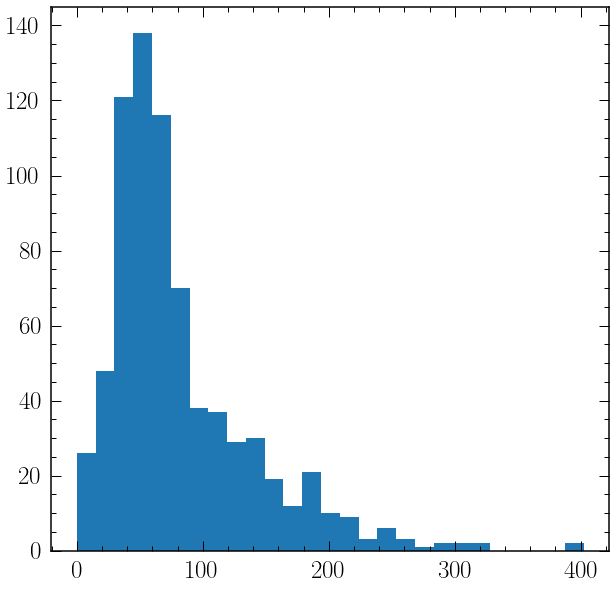

In [533]:
snrs=np.zeros(len(tr_ID))
for i in range(len(tr_ID)):
    snrs[i]=calc_SNR(tr_flux[i,:], tr_ivar[i,:])
plt.hist(snrs,bins=int(np.sqrt(len(tr_ID))))
    

(582,)
(4096,)
(582, 4096)
(582, 4096)
(582, 7)


(array([127., 134.,  82.,  36.,  43.,  34.,  28.,  20.,  17.,  18.,  12.,
         10.,   3.,   6.,   3.,   1.,   1.,   3.,   2.,   0.,   0.,   0.,
          0.,   2.]),
 array([ 40.0750772 ,  55.18608166,  70.29708611,  85.40809057,
        100.51909502, 115.63009948, 130.74110393, 145.85210839,
        160.96311284, 176.0741173 , 191.18512175, 206.29612621,
        221.40713066, 236.51813512, 251.62913957, 266.74014402,
        281.85114848, 296.96215293, 312.07315739, 327.18416184,
        342.2951663 , 357.40617075, 372.51717521, 387.62817966,
        402.73918412]),
 <BarContainer object of 24 artists>)

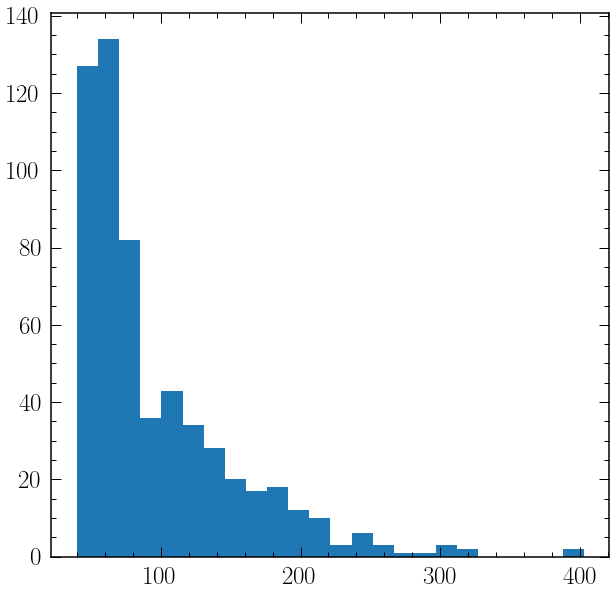

In [535]:
# get ride of low SNR stars
snrs=np.zeros(len(tr_ID))
for i in range(len(tr_ID)):
    snrs[i]=calc_SNR(tr_flux[i,:], tr_ivar[i,:])
m=snrs>40
tr_ID,tr_flux,tr_ivar,tr_label=tr_ID[m],tr_flux[m,:],tr_ivar[m,:],tr_label[m,:]

print(tr_ID.shape)
print(wl_all.shape)
print(tr_flux.shape)
print(tr_ivar.shape)
print(tr_label.shape)

plt.hist(snrs,bins=int(np.sqrt(len(tr_ID))))

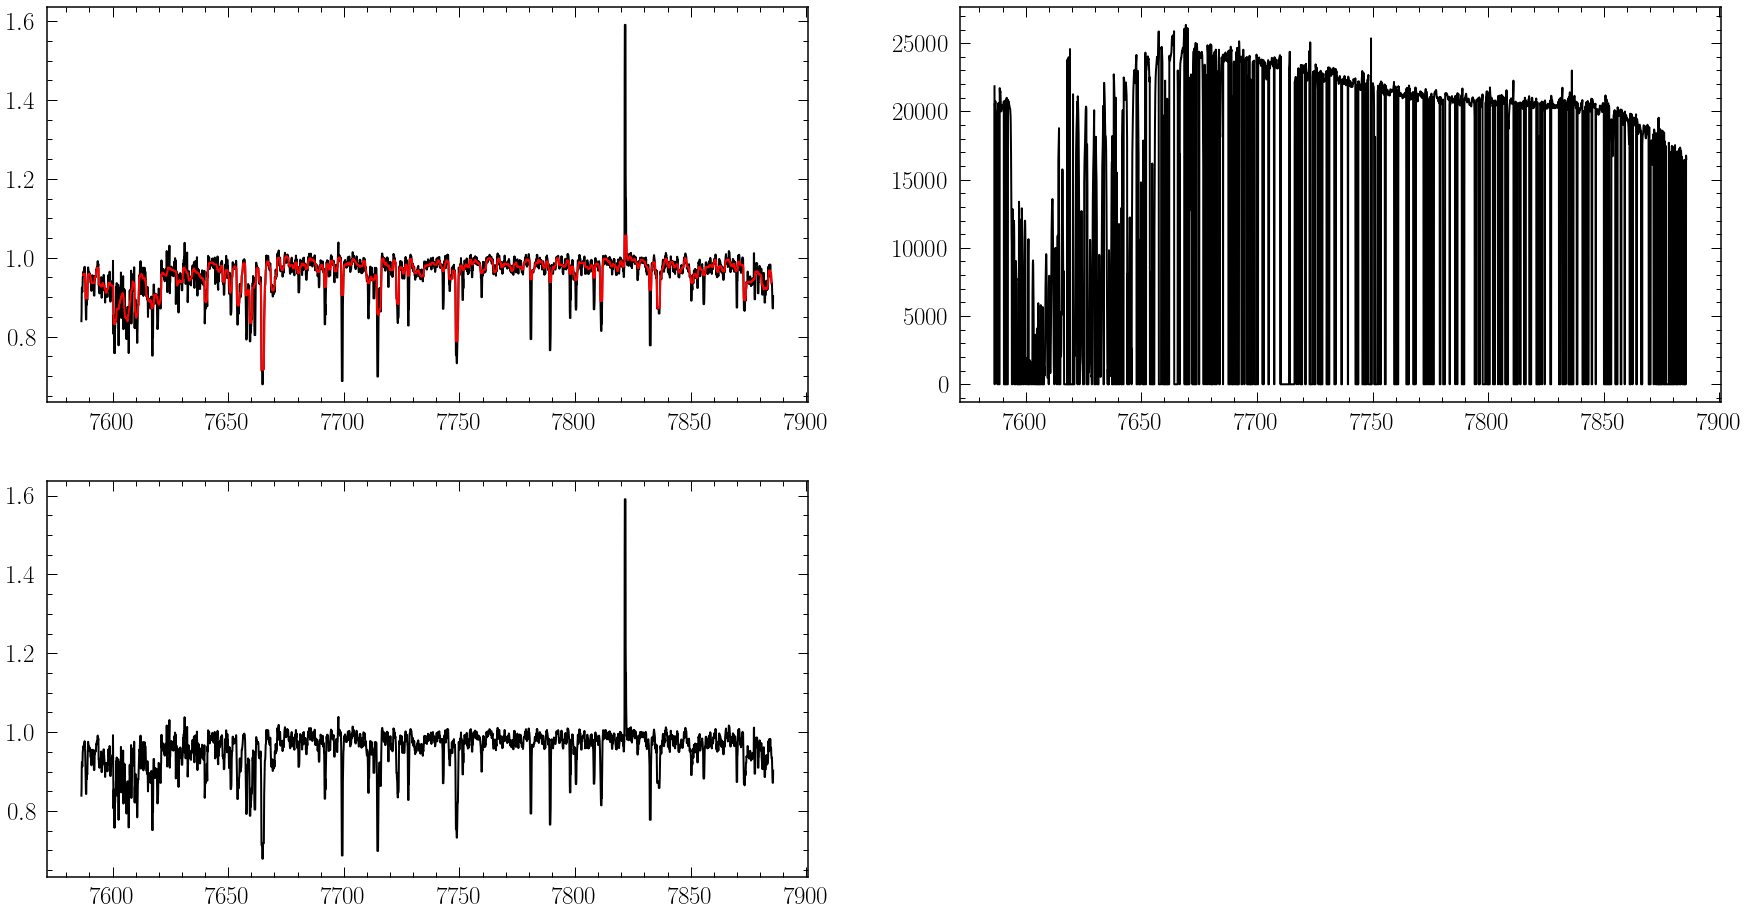

In [520]:
pltnumb=0
softenp=20
# plot one spectra
plt.figure(figsize=(30,16))
plt.subplot(2,2,1)
plt.plot(wl_all,tr_flux[pltnumb,:],'k-')
flux_errs=np.sqrt(1/tr_ivar[pltnumb,:])*tr_flux[pltnumb,:]
normflux,outs=get_outliers(tr_flux[pltnumb,:], flux_errs, softenp=softenp, f=3)
plt.plot(wl_all,normflux,'r-')
plt.plot(wl_all[outs],tr_flux[pltnumb,:][outs],'b.',markersize=15)
#plt.xlim([7820,7830])

plt.subplot(2,2,2)
plt.plot(wl_all,tr_ivar[pltnumb,:],'k-')


plt.subplot(2,2,3)
newflux, fewivar=replace_outliers(tr_flux[pltnumb,:], tr_ivar[pltnumb,:], softenp=softenp, f=3)
plt.plot(wl_all,newflux,'k-')



In [ ]:
for i in range(len(tr_ID)):
    pltnumb=i
    # plot one spectra
    plt.figure(figsize=(30,8))
    plt.subplot(1,2,1)
    plt.plot(wl_all,tr_flux[pltnumb,:],'k-')
    plt.title(str(i))
    #plt.xlim([4600,5000])

    plt.subplot(1,2,2)
    plt.plot(wl_all,tr_ivar[pltnumb,:],'k-')
    
    #plt.yscale('log')
    #plt.yscale('log')
    #plt.savefig(str(i)+'.png')


In [538]:
# get ride of bard stars

badstars=[32,54,178]
tr_ID=np.delete(tr_ID,badstars)
tr_flux=np.delete(tr_flux,badstars,axis=0)
tr_ivar=np.delete(tr_ivar,badstars,axis=0)
tr_label=np.delete(tr_label,badstars,axis=0)

print(tr_ID.shape)
print(wl_all.shape)
print(tr_flux.shape)
print(tr_ivar.shape)
print(tr_label.shape)



(579,)
(4096,)
(579, 4096)
(579, 4096)
(579, 7)


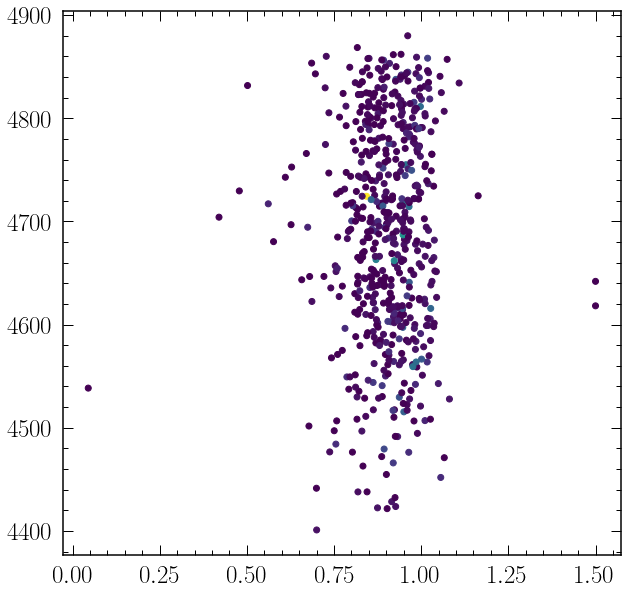

In [539]:
plt.scatter(tr_flux[:,1000],tr_label[:,1],c=tr_ivar[:,1000])


In [540]:
test_ID = tr_ID
test_flux = tr_flux
test_ivar = tr_ivar


In [541]:
from TheCannon import dataset
ds = dataset.Dataset(wl_all, tr_ID, tr_flux, tr_ivar, 
                     tr_label, test_ID, test_flux, test_ivar)

Loading dataset
This may take a while...


In [542]:
ds.set_label_names(labelnames)

Diagnostic for SNRs of reference and survey objects


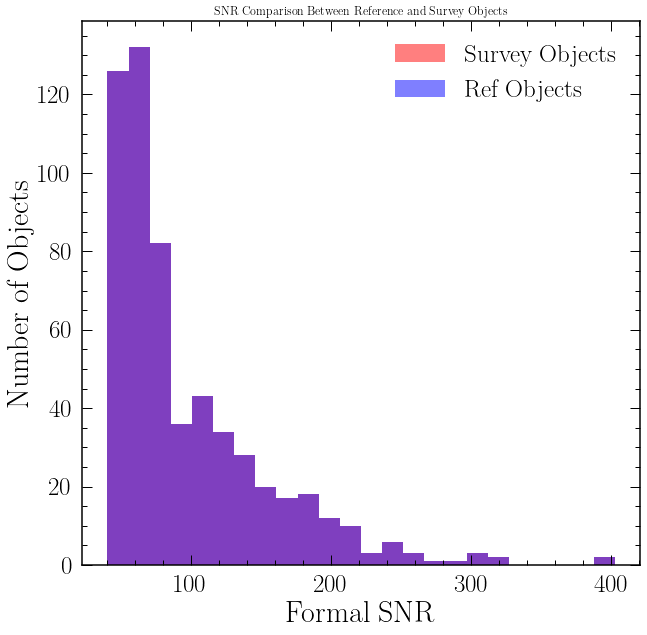

In [543]:
fig = ds.diagnostics_SNR()

In [544]:
from TheCannon import model
md = model.CannonModel(2, useErrors=False)
md.fit(ds)



Done training model. 


In [545]:

md.diagnostics_plot_chisq(ds)


Diagnostic plot: histogram of the red chi squareds of the fit
Saved as modelfit_chisqs.png


In [546]:
label_errs = md.infer_labels(ds)
test_labels = ds.test_label_vals
ds.diagnostics_1to1()



Inferring Labels
Error - curve_fit failed


/opt/homebrew/anaconda3/lib/python3.8/site-packages/TheCannon/infer_labels.py:113: RuntimeWarning: invalid value encountered in sqrt
  errs_all[jj,:] = np.sqrt(covs.diagonal())


Diagnostic for label output vs. input
Saved fig 1to1_label_0.png
Diagnostic for label output vs. input
Saved fig 1to1_label_1.png
Diagnostic for label output vs. input
Saved fig 1to1_label_2.png
Diagnostic for label output vs. input
Saved fig 1to1_label_3.png
Diagnostic for label output vs. input
Saved fig 1to1_label_4.png
Diagnostic for label output vs. input
Saved fig 1to1_label_5.png
Diagnostic for label output vs. input
Saved fig 1to1_label_6.png


Diagnostic plot: leading coeffs and scatters across wavelength.


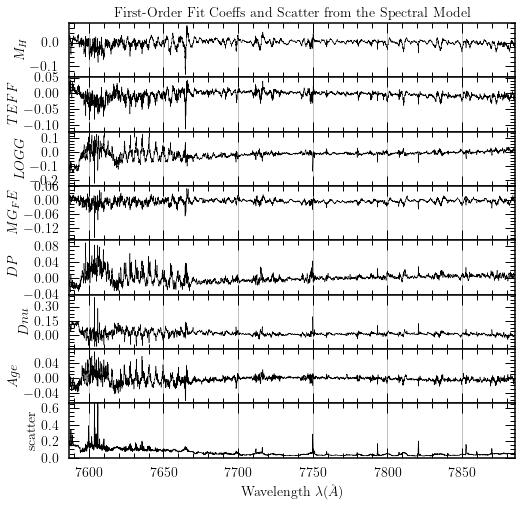

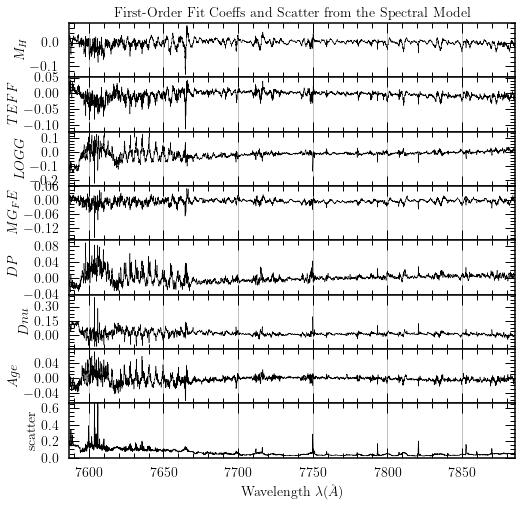

In [547]:
md.diagnostics_leading_coeffs(ds)



In [551]:
print(np.shape(test_labels))
print(np.shape(tr_label))



(579, 7)
(579, 7)


In [594]:
import matplotlib.gridspec as gridspec

def diagnostics_1to1_self(df, figname="1to1_label"):
        """ Plots survey labels vs. training labels, color-coded by survey SNR """
        snr = df.test_SNR
        label_names = df.get_plotting_labels()
        nlabels = len(label_names)
        reference_labels = df.tr_label
        test_labels = df.test_label_vals
        
        m=test_labels[:,0]>-100
        reference_labels=reference_labels[m,:]
        test_labels=test_labels[m,:]
        snr=snr[m]

        for i in range(nlabels):
            name = label_names[i]
            orig = reference_labels[:,i]
            cannon = test_labels[:,i]
            # calculate bias and scatter
            scatter = np.round(np.std(orig-cannon),5)
            bias  = np.round(np.mean(orig-cannon),5)

            low = np.minimum(min(orig), min(cannon))
            high = np.maximum(max(orig), max(cannon))

            fig = plt.figure(figsize=(10,6))
            gs = gridspec.GridSpec(1,2,width_ratios=[2,1], wspace=0.3)
            ax1 = plt.subplot(gs[0])
            ax2 = plt.subplot(gs[1])
            ax1.plot([low, high], [low, high], 'k-', linewidth=2.0, label="x=y")
            ax1.set_xlim(low, high)
            ax1.set_ylim(low, high)
            ax1.legend(fontsize=14, loc='lower right')
            pl = ax1.scatter(orig, cannon, marker='x', c=snr,
                    vmin=50, vmax=200, alpha=0.7)
            cb = plt.colorbar(pl, ax=ax1, orientation='horizontal')
            cb.set_label('SNR from Test Set', fontsize=12)
            textstr = 'Scatter: %s \nBias: %s' %(scatter, bias)
            ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
                    fontsize=14, verticalalignment='top')
            ax1.tick_params(axis='x', labelsize=14)
            ax1.tick_params(axis='y', labelsize=14)
            ax1.set_xlabel("Reference Value", fontsize=14)
            ax1.set_ylabel("Cannon Test Value", fontsize=14)
            ax1.set_title("1-1 Plot of Label " + r"$%s$" % name)
            diff = cannon-orig
            npoints = len(diff)
            mu = np.mean(diff)
            sig = np.std(diff)
            #ax2.hist(diff, orientation='horizontal')
            ax2.hist(diff, range=[-3*sig,3*sig], color='k', bins=int(np.sqrt(npoints)),
                    orientation='horizontal', alpha=0.3, histtype='stepfilled')
            ax2.tick_params(axis='x', labelsize=14)
            ax2.tick_params(axis='y', labelsize=14)
            ax2.set_xlabel("Count", fontsize=14)
            ax2.set_ylabel("Difference", fontsize=14)
            ax2.axhline(y=0, c='k', lw=3, label='Difference=0')
            ax2.set_title("Training Versus Test Labels for $%s$" %name,
                    fontsize=14)
            ax2.legend(fontsize=14)
            print("Diagnostic for label output vs. input")
            plt.show()

Diagnostic for label output vs. input


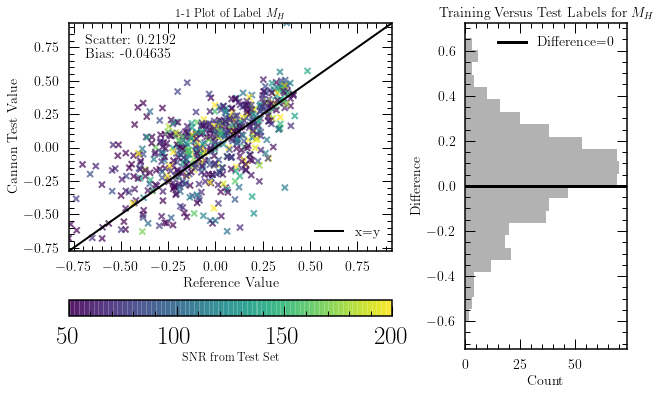

Diagnostic for label output vs. input


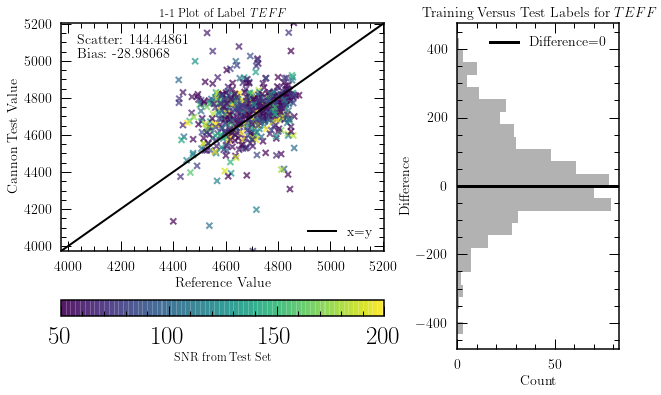

Diagnostic for label output vs. input


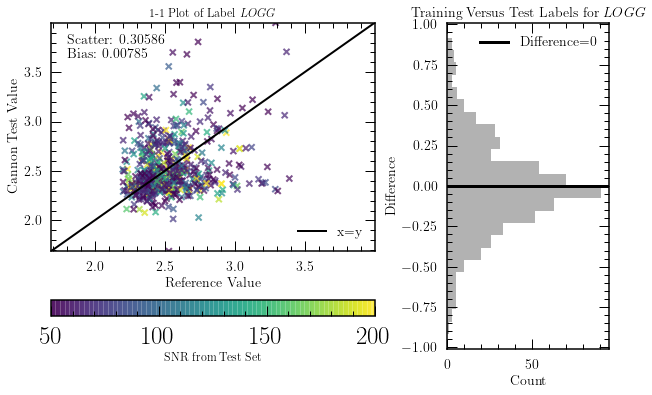

Diagnostic for label output vs. input


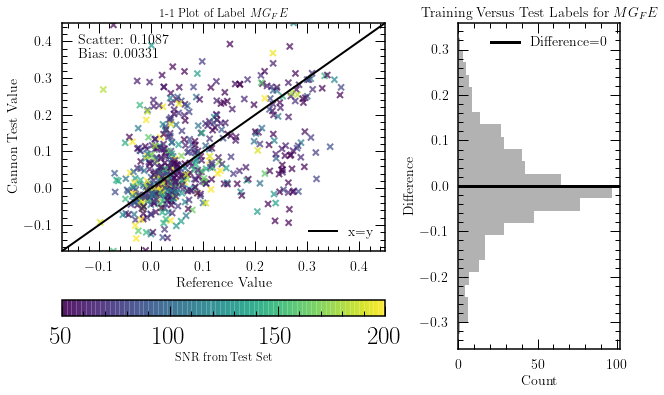

Diagnostic for label output vs. input


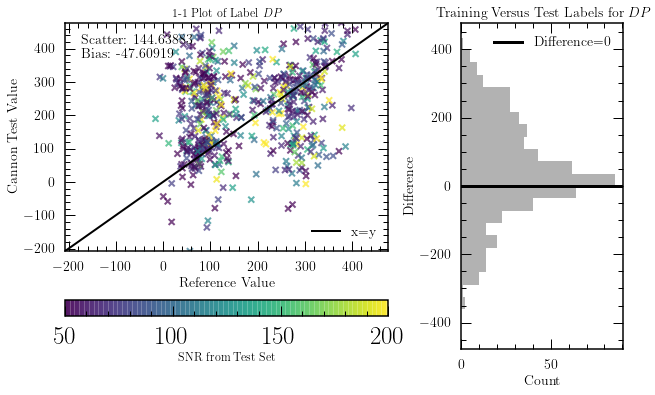

Diagnostic for label output vs. input


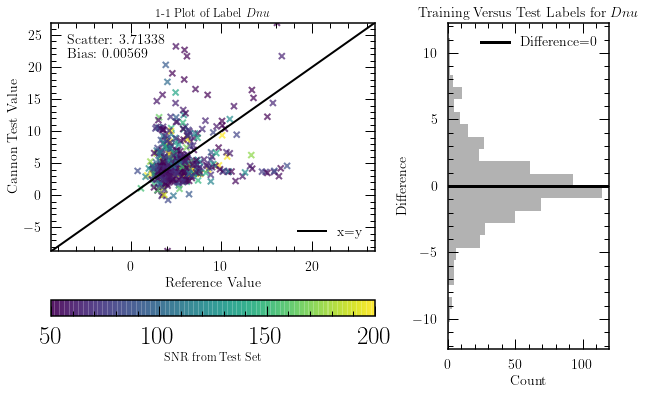

Diagnostic for label output vs. input


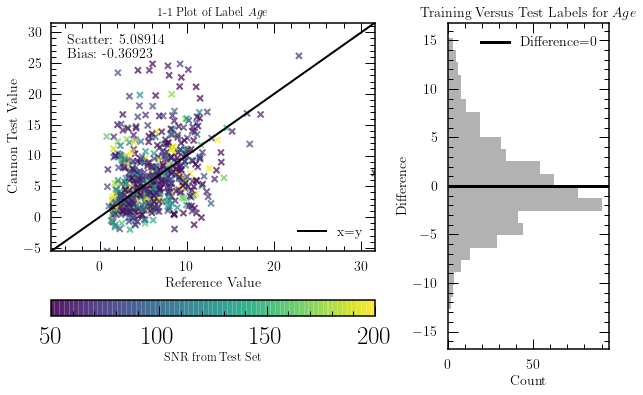

In [595]:
# first cleanup, getting rid of outlisers
diagnostics_1to1_self(ds)

# Train without DP Dnu

In [703]:
tr_ID=useablespec[:,-1]
tr_flux=np.zeros((np.shape(useablespec)[0],4096*4))
tr_ivar=np.zeros((np.shape(useablespec)[0],4096*4))
wl_all=np.zeros(4096*4)

for i in range(4):
    wl_all[4096*i:4096*(i+1)]=wl[:,i]
    for j in range(len(tr_ID)):
        tr_flux[j,4096*i:4096*(i+1)]=fluxs[:,i,j]
        tr_ivar[j,4096*i:4096*(i+1)]=abs(ivars[:,i,j])
        
        
m=(wl_all<7586)|(wl_all>7700)
m=m&(wl_all>5000)
wl_all,tr_flux,tr_ivar=wl_all[m],tr_flux[:,m],tr_ivar[:,m]

In [704]:
# get training labels from APOGEE
# get the dataframe for labels not including Dp Dnu
labels=galah_apogee.loc[pd.DataFrame(spec).dropna().index]

cannonage=pd.read_pickle('../SecondYear/CannonDR16.pkl')
labels=labels.merge(cannonage[['APOGEE_ID','Age']], left_on='APOGEE_ID',right_on='APOGEE_ID',how="inner")


labelnames=['M_H','TEFF','LOGG','MG_FE','Age']

tr_label=labels[labelnames].values




In [705]:
"""
i=3
wl_all=wl_all[4096*i:4096*(i+1)]
tr_flux=tr_flux[:,4096*i:4096*(i+1)]
tr_ivar=tr_ivar[:,4096*i:4096*(i+1)]
"""




'\ni=3\nwl_all=wl_all[4096*i:4096*(i+1)]\ntr_flux=tr_flux[:,4096*i:4096*(i+1)]\ntr_ivar=tr_ivar[:,4096*i:4096*(i+1)]\n'

In [713]:
print(tr_ID.shape)
print(wl_all.shape)
print(tr_flux.shape)
print(tr_ivar.shape)
print(tr_label.shape)



(610,)
(10734,)
(610, 10734)
(610, 10734)
(610, 5)


(array([112., 130.,  81.,  58.,  57.,  38.,  28.,  25.,  17.,  16.,  11.,
          8.,   7.,   6.,   1.,   7.,   2.,   0.,   2.,   0.,   1.,   0.,
          1.,   2.]),
 array([ 30.01372391,  40.06484646,  50.11596901,  60.16709156,
         70.21821411,  80.26933666,  90.32045921, 100.37158176,
        110.42270431, 120.47382686, 130.52494941, 140.57607196,
        150.62719451, 160.67831706, 170.72943961, 180.78056216,
        190.83168471, 200.88280726, 210.93392981, 220.98505235,
        231.0361749 , 241.08729745, 251.13842   , 261.18954255,
        271.2406651 ]),
 <BarContainer object of 24 artists>)

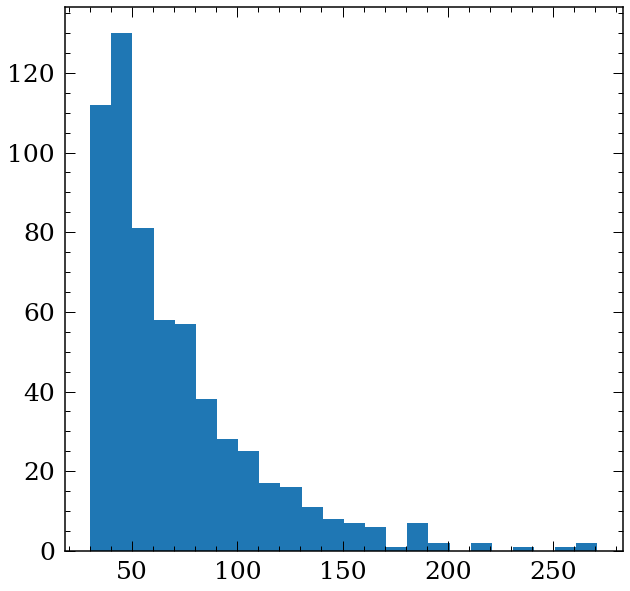

In [714]:
snrs=np.zeros(len(tr_ID))
for i in range(len(tr_ID)):
    snrs[i]=calc_SNR(tr_flux[i,:], tr_ivar[i,:])
plt.hist(snrs,bins=int(np.sqrt(len(tr_ID))))
    

(498,)
(10734,)
(498, 10734)
(498, 10734)
(498, 5)


(array([137.,  79.,  58.,  59.,  37.,  28.,  24.,  18.,  14.,  12.,   6.,
          7.,   3.,   3.,   7.,   0.,   2.,   0.,   1.,   0.,   1.,   2.]),
 array([ 40.07447383,  50.58202798,  61.08958213,  71.59713628,
         82.10469042,  92.61224457, 103.11979872, 113.62735287,
        124.13490702, 134.64246117, 145.15001532, 155.65756947,
        166.16512362, 176.67267776, 187.18023191, 197.68778606,
        208.19534021, 218.70289436, 229.21044851, 239.71800266,
        250.22555681, 260.73311095, 271.2406651 ]),
 <BarContainer object of 22 artists>)

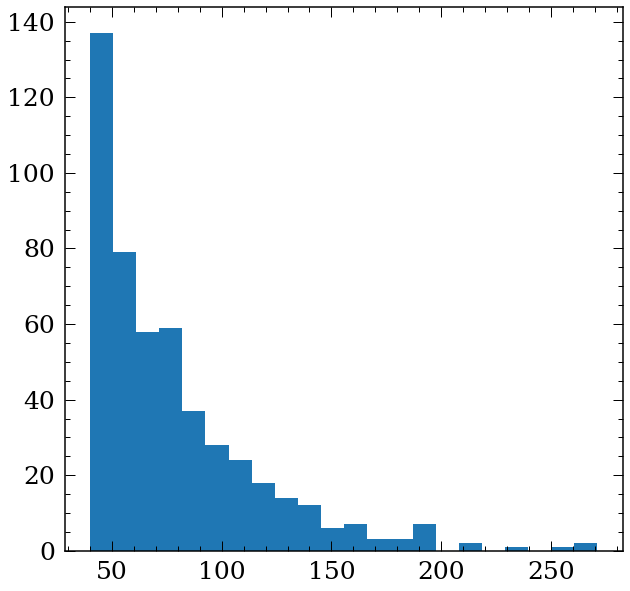

In [718]:
# get ride of low SNR stars
snrs=np.zeros(len(tr_ID))
for i in range(len(tr_ID)):
    snrs[i]=calc_SNR(tr_flux[i,:], tr_ivar[i,:])
m=snrs>40
tr_ID,tr_flux,tr_ivar,tr_label=tr_ID[m],tr_flux[m,:],tr_ivar[m,:],tr_label[m,:]

print(tr_ID.shape)
print(wl_all.shape)
print(tr_flux.shape)
print(tr_ivar.shape)
print(tr_label.shape)

plt.hist(snrs,bins=int(np.sqrt(len(tr_ID))))

In [719]:
test_ID = tr_ID
test_flux = tr_flux
test_ivar = tr_ivar



In [720]:
from TheCannon import dataset
ds = dataset.Dataset(wl_all, tr_ID, tr_flux, tr_ivar, 
                     tr_label, test_ID, test_flux, test_ivar)

Loading dataset
This may take a while...


In [721]:
ds.set_label_names(labelnames)

Diagnostic for SNRs of reference and survey objects


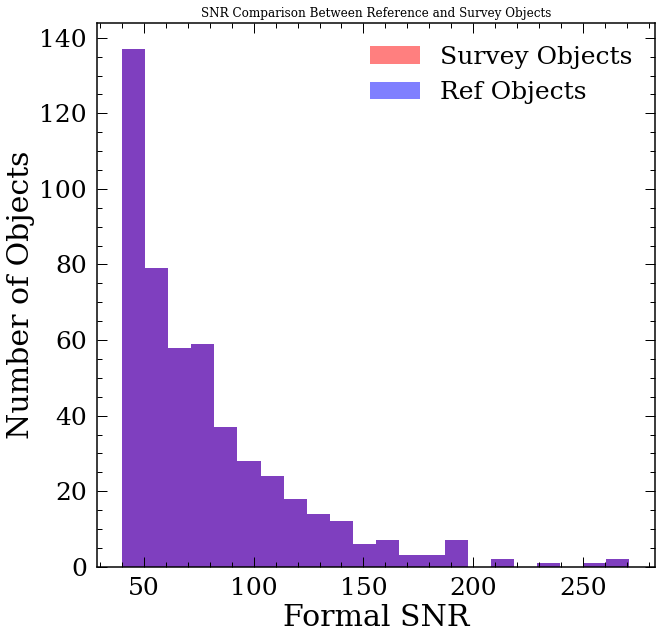

In [722]:
fig = ds.diagnostics_SNR()

In [723]:
from TheCannon import model
md = model.CannonModel(2, useErrors=False)
md.fit(ds)


Done training model. 


Inferring Labels
Error - curve_fit failed


/opt/homebrew/anaconda3/lib/python3.8/site-packages/TheCannon/infer_labels.py:113: RuntimeWarning: invalid value encountered in sqrt
  errs_all[jj,:] = np.sqrt(covs.diagonal())


Diagnostic plot: leading coeffs and scatters across wavelength.


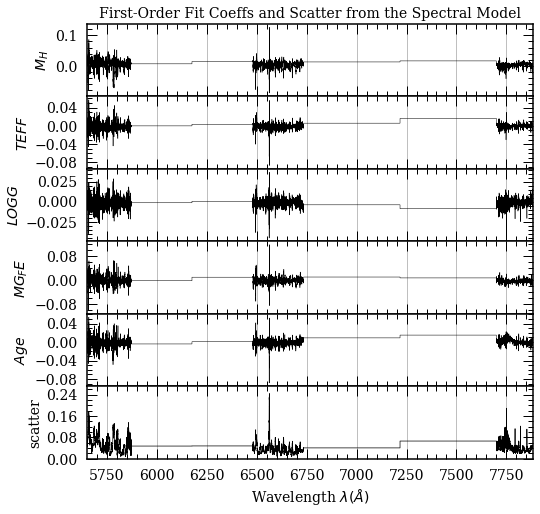

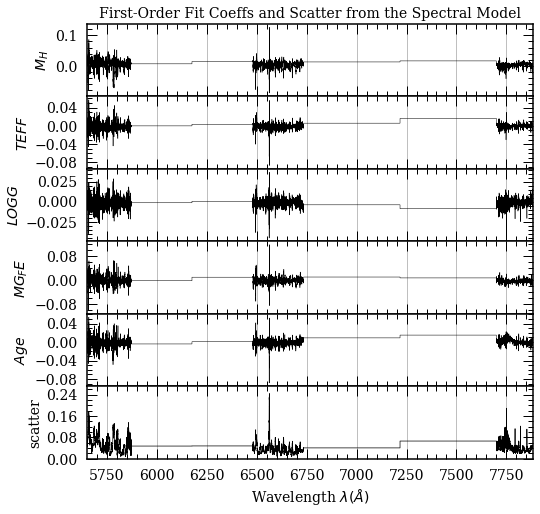

In [724]:
label_errs = md.infer_labels(ds)
test_labels = ds.test_label_vals
md.diagnostics_leading_coeffs(ds)



In [725]:
import matplotlib.gridspec as gridspec

def diagnostics_1to1_self(df, figname="1to1_label"):
        """ Plots survey labels vs. training labels, color-coded by survey SNR """
        snr = df.test_SNR
        label_names = df.get_plotting_labels()
        nlabels = len(label_names)
        reference_labels = df.tr_label
        test_labels = df.test_label_vals
        
        m=test_labels[:,0]>-100
        reference_labels=reference_labels[m,:]
        test_labels=test_labels[m,:]
        snr=snr[m]

        for i in range(nlabels):
            name = label_names[i]
            orig = reference_labels[:,i]
            cannon = test_labels[:,i]
            # calculate bias and scatter
            scatter = np.round(np.std(orig-cannon),5)
            bias  = np.round(np.mean(orig-cannon),5)

            low = np.minimum(min(orig), min(cannon))
            high = np.maximum(max(orig), max(cannon))

            fig = plt.figure(figsize=(10,6))
            gs = gridspec.GridSpec(1,2,width_ratios=[2,1], wspace=0.3)
            ax1 = plt.subplot(gs[0])
            ax2 = plt.subplot(gs[1])
            ax1.plot([low, high], [low, high], 'k-', linewidth=2.0, label="x=y")
            ax1.set_xlim(low, high)
            ax1.set_ylim(low, high)
            ax1.legend(fontsize=14, loc='lower right')
            pl = ax1.scatter(orig, cannon, marker='x', c=snr,
                    vmin=50, vmax=200, alpha=0.7)
            cb = plt.colorbar(pl, ax=ax1, orientation='horizontal')
            cb.set_label('SNR from Test Set', fontsize=12)
            textstr = 'Scatter: %s \nBias: %s' %(scatter, bias)
            ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
                    fontsize=14, verticalalignment='top')
            ax1.tick_params(axis='x', labelsize=14)
            ax1.tick_params(axis='y', labelsize=14)
            ax1.set_xlabel("Reference Value", fontsize=14)
            ax1.set_ylabel("Cannon Test Value", fontsize=14)
            ax1.set_title("1-1 Plot of Label " + r"$%s$" % name)
            diff = cannon-orig
            npoints = len(diff)
            mu = np.mean(diff)
            sig = np.std(diff)
            #ax2.hist(diff, orientation='horizontal')
            ax2.hist(diff, range=[-3*sig,3*sig], color='k', bins=int(np.sqrt(npoints)),
                    orientation='horizontal', alpha=0.3, histtype='stepfilled')
            ax2.tick_params(axis='x', labelsize=14)
            ax2.tick_params(axis='y', labelsize=14)
            ax2.set_xlabel("Count", fontsize=14)
            ax2.set_ylabel("Difference", fontsize=14)
            ax2.axhline(y=0, c='k', lw=3, label='Difference=0')
            ax2.set_title("Training Versus Test Labels for $%s$" %name,
                    fontsize=14)
            ax2.legend(fontsize=14)
            print("Diagnostic for label output vs. input")
            plt.show()

Diagnostic for label output vs. input


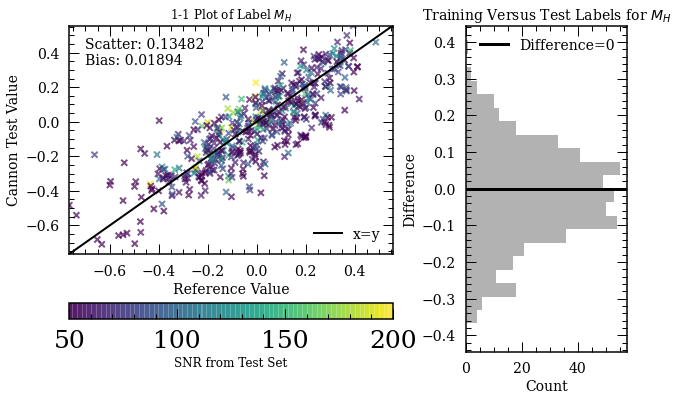

Diagnostic for label output vs. input


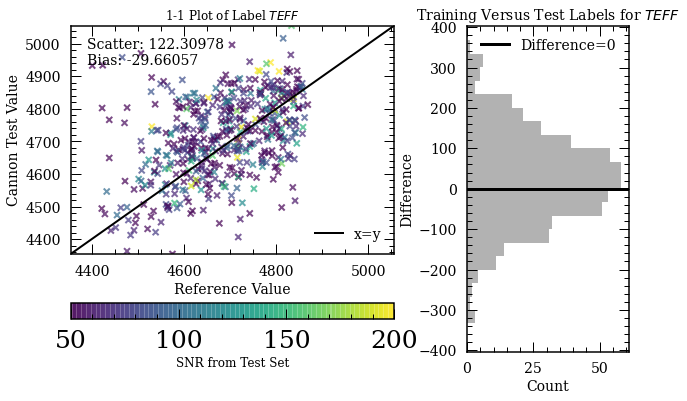

Diagnostic for label output vs. input


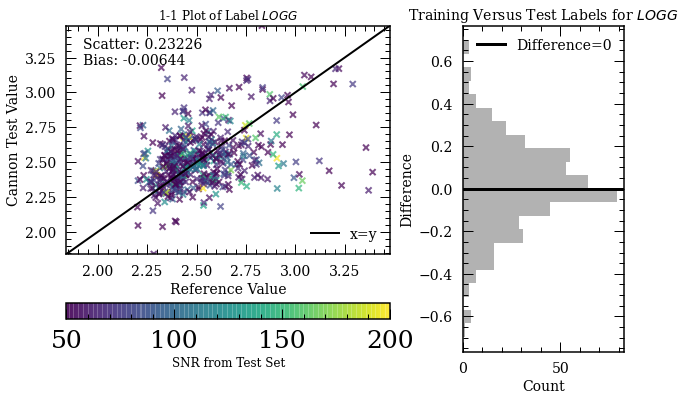

Diagnostic for label output vs. input


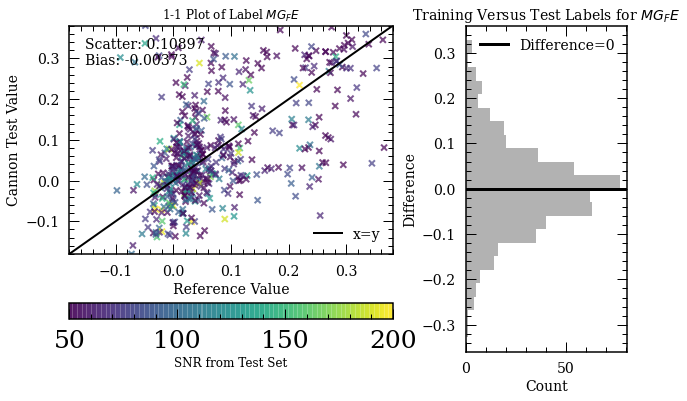

Diagnostic for label output vs. input


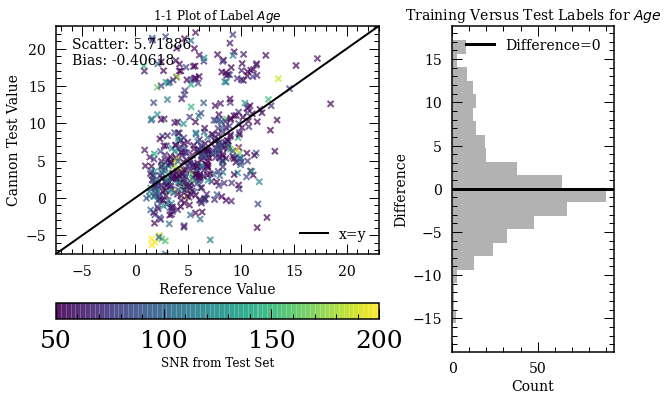

In [726]:
# first cleanup, getting rid of outlisers
diagnostics_1to1_self(ds)

6480.07763671871 6734.878103417812
6480.07763671871 6734.878103417812
6480.07763671871 6734.878103417812
6480.07763671871 6734.878103417812
6480.07763671871 6734.878103417812


Text(0, 0.5, 'scatter')

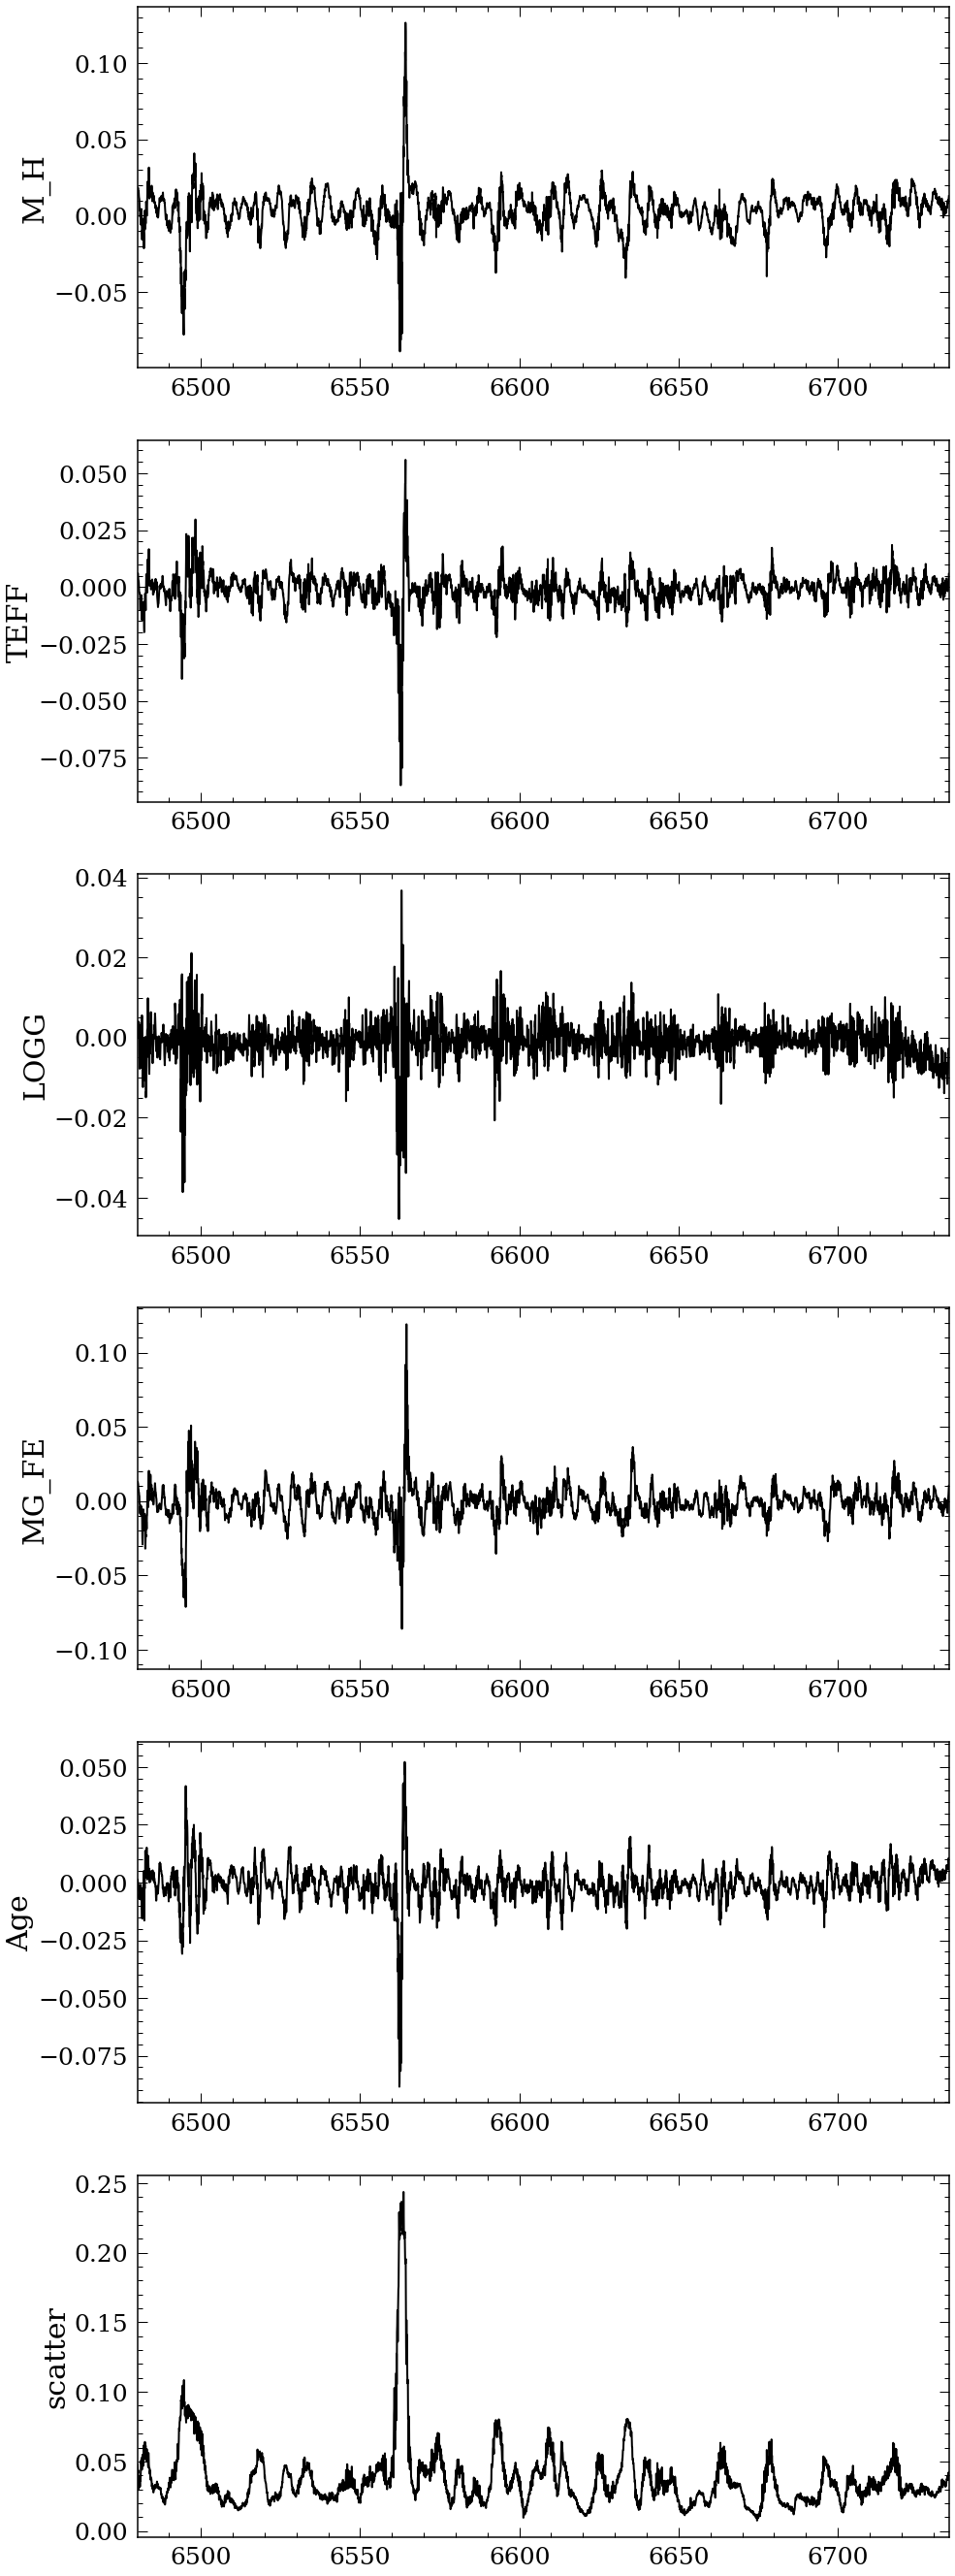

In [729]:
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {'text.usetex': False}
plt.rcParams.update(params)

rangecheck=2

labels_pltt=ds.get_plotting_labels()
plt.figure(figsize=(15,48))
coefs=md.coeffs
for i in range(5):
    coef=coefs[:,i+1]
    plt.subplot(6,1,i+1)
    for j in range(4):
        wlsing=wl_all[4096*j:4096*(j+1)]
        coef_wl=coef[4096*j:4096*(j+1)]
        plt.plot(wlsing,coef_wl,'k-')
        if j+1==rangecheck:
            minwl=min(wlsing)
            maxwl=max(wlsing)
            print(minwl,maxwl)
            plt.xlim([min(wlsing),max(wlsing)])
            
    plt.ylabel(labels_pltt[i])
    
plt.subplot(6,1,6)
plt.plot(wl_all,md.scatters,'k-')
plt.xlim([minwl,maxwl])
plt.ylabel('scatter')

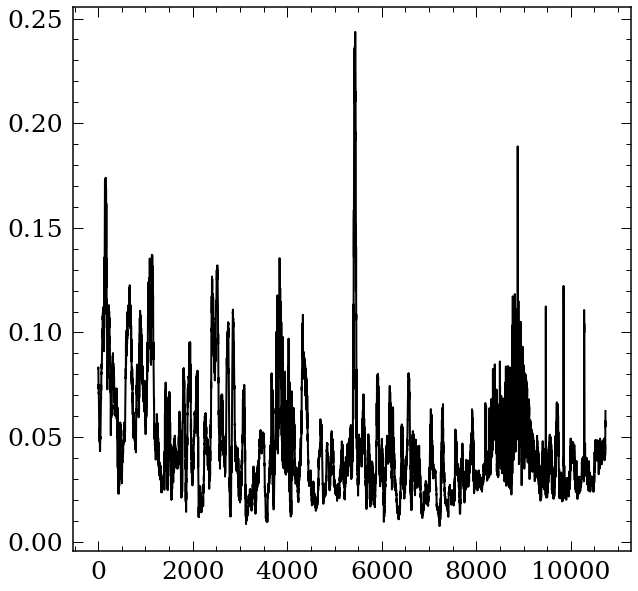

In [727]:
plt.plot(md.scatters,'k-')